In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim

import numpy as np

import time
import math

import matplotlib.pyplot as plt

import tqdm

import easydict

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

In [2]:

class MultiHeadAttention(nn.Module):
    def __init__(self, 
                 emb_dim: int, 
                 num_heads: int, 
                 drop_out: float = 0.0,
                 bias: bool = False, 
                 encoder_decoder_attention: bool = False,
                 causal: bool = False):
        '''Initialize MultiHeadAttention class variables.
        
        Args:
            emb_dim (int): Dimension of a word * number of heads.
            num_heads (int): Number of attention heads.
            drop_out (float): Drop out rate.
            bias (bool): Boolean that indicating whether to use bias or not.
            encoder_decoder_attention (bool): Boolean that indicating whether the multi head
                                              attention is encoder-decoder attention or not.
            causal (bool): Boolean that indicating whether to use causal mask or not.
        '''
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads
        assert self.head_dim * num_heads == emb_dim, "emb_dim must be divisible by num_heads"
        
        self.drop_out = drop_out
        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal
        
        self.wk = nn.Linear(self.emb_dim, self.emb_dim, bias = bias)
        self.wq = nn.Linear(self.emb_dim, self.emb_dim, bias = bias)
        self.wv = nn.Linear(self.emb_dim, self.emb_dim, bias = bias)
        self.output = nn.Linear(self.emb_dim, self.emb_dim, bias = bias)
    
    def multi_head_scaled_dot_product(self,
                                      query: torch.Tensor,
                                      key: torch.Tensor,
                                      value: torch.Tensor,
                                      attention_mask: torch.BoolTensor):
        '''Perform multi-head version of scaled dot product.
        
        Args:
            query (Tensor): shape '(batch size, # attention head, seqence length, demension of head)'
            key (Tensor): shape '(batch size, # attention head, seqence length, demension of head)'
            value (Tensor): shape '(batch size, # attention head, seqence length, demension of head)'
            attention_mask: This mask can be either causal mask or padding mask.
                            shape '(batch size, source squence length)' for padding mask.
                            shape '(sequence length, target sequence length)' for causal mask.
        Returns:
            attn_output (Tensor): output of attention mechanism. shape '(batch size, seq_len, emb_dim)'
            attn_weights (Tensor): value of attention weight of each word. shape '(batch size, # attn head, seq_len, seq_len)'
        '''
        
        attn_weights = torch.matmul(query, key.transpose(-1,-2)) / math.sqrt(self.head_dim)
        '''shape of attn_weights : (batch size, # attn head, seq_len, seq_len)'''
        
        if attention_mask is not None:
            if self.causal:
                '''Masking future info for encoder-decoder attention.'''
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(0).unsqueeze(1), float('-inf'))
                '''
                shape of attention_mask : (trg_len, trg_len).
                shape of attention_mask.unsqueeze(0).unsqueeze(1) : (1, 1, trg_len, trg_len).
                '''
            else:
                '''Masking padding token so that it is not used for attention.'''
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2), float('-inf'))
                '''
                shape of attention_mask : (batch_size, src_len)
                shape of attention_mask.unsqueeze(1).unsqueeze(2) : (batch_size, 1, 1, src_len)
                '''
        attn_weights = F.softmax(attn_weights, dim = -1)
        attn_probs = F.dropout(attn_weights, p=self.drop_out, training=self.training)
        
        attn_output = torch.matmul(attn_probs, value)
        '''shape of attn_output : (batch size, # attn head, seq_len, head_dim)'''
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        '''shape of attn_output : (batch size, seq_len, # attn head, head_dim)'''
        shape = attn_output.size()[:-2] + (self.emb_dim,)
        attn_output = attn_output.view(*shape)
        '''shape of attn_output : (batch size, seq_len, emb_dim)'''
        attn_output = self.output(attn_output)
        
        return attn_output, attn_weights
    
    def transform_to_multi_head(self, 
                                x: torch.Tensor):
        ''' Reshape input
        
        Args:
            x (Tensor): shape '(batch_size, seq_len, emb_dim)'
        
        Returns:
            Tensor: shape '(batch_size, # attn head, seq_len, head_dim)'
        '''
        
        shape = x.size()[:-1] + (self.num_heads, self.head_dim,)
        x = x.view(*shape)
        
        return x.permute(0, 2, 1, 3)
    
    def forward(self,
                query: torch.Tensor,
                key: torch.Tensor,
                attention_mask: torch.Tensor = None):
        '''
        Args:
            query (Tensor): shape '(batch_size, seq_len, emb_dim)'
            key (Tensor): shape '(batch_size, seq_len, emb_dim)'
            attention_mask (Tensor): shape '(batch size, squence length)' for padding mask.
                                     shape '(sequence length, sequence length)' for causal mask.
        
        Returns:
            attn_output (Tensor): output of attention mechanism. shape '(batch size, seq_len, emb_dim)'
            attn_weights (Tensor): value of attention weight of each word. shape '(batch size, # attn head, seq_l
        '''
        
        q = self.wq(query)
        
        # encoder-decoder attention
        if self.encoder_decoder_attention:
            '''
            query is output of encoder
            key is input of decoder
            '''
            k = self.wk(key)
            v = self.wv(key)
        
        # self attention
        else:
            '''
            Both of query and key are input of encoder(query is same with key).
            '''
            k = self.wk(query)
            v = self.wv(query)
        
        q = self.transform_to_multi_head(q)
        k = self.transform_to_multi_head(k)
        v = self.transform_to_multi_head(v)
        
        attn_output, attn_weights = self.multi_head_scaled_dot_product(q,k,v,attention_mask)
            
        return attn_output, attn_weights

In [3]:
# temp_mha = MultiHeadAttention(emb_dim=512, num_heads=8)
# x = torch.rand(3, 45, 512)
# out, attn = temp_mha(query=x, key=x, attention_mask=None)
# print(out.size(), attn.size())

torch.Size([3, 45, 512]) torch.Size([3, 8, 45, 45])


In [3]:
class PositionWiseFeedForward(nn.Module):
    
    def __init__(self,
                 emb_dim: int,
                 hid_dim: int,
                 drop_out: float = 0.1):
        '''Initialize position-wise feed forward network.
        
        Args:
            emb_dim (int): word embdding dimension.
            hid_dim (int): hidden dimesion.
            drop_out (float): drop out rate.
        '''
        super().__init__()
        self.linear_1 = nn.Linear(emb_dim, hid_dim)
        self.linear_2 = nn.Linear(hid_dim, emb_dim)
        self.activation = nn.ReLU()
        self.drop_out = drop_out
    
    def forward(self,
                 x: torch.Tensor):
        '''
        Args:
            x (Tensor): shape '(batch_size, seq_len, emb_dim)'
        
        Return:
            x (Tensor): shape '(batch_size, seq_len, emb_dim)'
        '''

        x = self.linear_1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_out, training=self.training)
        
        x = self.linear_2(x)
        x = F.dropout(x, p=self.drop_out, training=self.training)
        
        return x

In [5]:
# temp_pwff = PositionWiseFeedForward(512, 256)
# x = torch.rand(3, 45, 512)
# out = temp_pwff(x)
# print(out.size())

torch.Size([3, 45, 512])


In [4]:
class SinusoidalPositionalEncodedEmbedding(nn.Embedding):
    def __init__(self, 
                 max_position: int, 
                 embedding_dim: int):
        '''Initialize positional embedding.
        
        Args:
            max_position (int): maximum length of input sequence length.
                                 That is, it can encode position up to max_positions'th position.
            embedding_dim (int): embedding dimension.
        '''
        super().__init__(max_position, embedding_dim)
        self.weight = self._init_weight(self.weight)

    def _init_weight(self, initial_embedding_table: nn.Parameter):
        '''Make positional embedding table
        
        Args:
            initial_embedding_table (Parameter): initialized embedding table.
        
        Returns:
            pe (Parameter): position embedding table.
        
        '''
        max_pos, emb_dim = initial_embedding_table.shape
        pe = nn.Parameter(torch.zeros(max_pos, emb_dim))

        pos_id = torch.arange(0, max_pos).unsqueeze(1)
        freq = torch.pow(10000., -torch.arange(0, emb_dim, 2, dtype=torch.float) / emb_dim)
        pos_freq = pos_id * freq
        pe[:, 0::2] = torch.sin(pos_freq)
        pe[:, 1::2] = torch.cos(pos_freq)
        
        pe.detach_()
        
        return pe

    def forward(self, 
                input_ids: torch.Tensor):
        '''
        Args:
            input_ids (Tensor): shape '(batch_size, seq_len)'
        
        Return:
            Tensor : shape '(seq_len, emb_dim)'
        '''
        batch_size, seq_len = input_ids.shape[:2]
        positions = torch.arange(seq_len, dtype=torch.long, device=self.weight.device)
        return super().forward(positions)

torch.Size([512, 512])
torch.Size([64, 512])


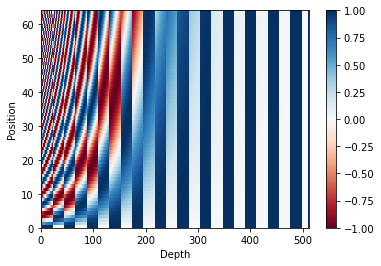

In [5]:
# pos = SinusoidalPositionalEncodedEmbedding(512, 512)
# pos_encoding = pos(torch.zeros(2, 64, 512))
# print(pos.weight.shape)
# print(pos_encoding.shape)
# plt.pcolormesh(pos_encoding.numpy(), cmap='RdBu')
# plt.xlabel('Depth')
# plt.xlim((0, 512))
# plt.ylabel('Position')
# plt.colorbar()
# plt.show()

In [8]:
# config = easydict.EasyDict({
#     "emb_dim":6,
#     "ffn_dim":256,
#     "num_attention_heads":2,
#     "attention_drop_out":0.0,
#     "drop_out":0.2,
#     "max_position":512,
#     "num_encoder_layers":3,
#     "num_decoder_layers":3,
    
# })

In [5]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 config):
        '''Initialize encoder layer
        
        Args:
            config (Config): configuration parameters.
        '''
        
        super().__init__()

        self.drop_out = config.drop_out
        
        # self multi-head attention
        self.self_attn = MultiHeadAttention(emb_dim = config.emb_dim,
                                            num_heads = config.num_attention_heads,
                                            drop_out = config.attention_drop_out)                      
        self.attn_layer_norm = nn.LayerNorm(config.emb_dim)
        
        #position-wise feed forward
        self.position_wise_feed_forward = PositionWiseFeedForward(config.emb_dim,
                                                               config.ffn_dim,
                                                               config.drop_out)
        self.feed_forward_layer_norm = nn.LayerNorm(config.emb_dim)
    
    def forward(self, 
                x: torch.Tensor, 
                encoder_padding_mask: torch.Tensor):
        '''
        Args:
            x (Tensor): shape '(batch_size, src_len, emb_dim)'
            encoder_padding_mask (Tensor): binary BoolTensor. shape '(batch_size, src_len)'
            
        Returns:
            x (Tensor): encoded output. shape '(batch_size, src_len, emb_dim)'
            self_attn_weights: self attention socre
        '''
        residual = x
        x, self_attn_weights = self.self_attn(query=x, 
                                              key=x, 
                                              attention_mask=encoder_padding_mask)
        x = F.dropout(x, p=self.drop_out, training = self.training)
        x = self.attn_layer_norm(x + residual)
        
        residual = x
        x = self.position_wise_feed_forward(x)
        x = self.attn_layer_norm(x + residual)
        
#         clamping
        if x.isnan().any() or x.isinf().any():
            clamp_value = torch.finfo(x.dtype).max - 1000
            x = torch.clamp(x, min = -clamp_value, max = clamp_value)
        return x, self_attn_weights

In [10]:
# x = torch.rand(3, 12, 6)
# padding_mask = torch.zeros(3,12, dtype=torch.bool)
# padding_mask[0,6:] = True
# padding_mask[1, 3:] = True
# padding_mask[2, 10:] = True


In [11]:
# temp_el = EncoderLayer(config)
# out, attn_weights = temp_el(x, padding_mask)

# '''패딩마스크가 잘 들어가고 있는지 확인.'''
# print(attn_weights.shape)
# print(attn_weights)

torch.Size([3, 2, 12, 12])
tensor([[[[0.1708, 0.1567, 0.1699, 0.1591, 0.1672, 0.1764, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.1740, 0.1586, 0.1638, 0.1631, 0.1702, 0.1703, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.1769, 0.1530, 0.1657, 0.1593, 0.1714, 0.1738, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.1707, 0.1583, 0.1694, 0.1611, 0.1684, 0.1722, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.1772, 0.1543, 0.1615, 0.1599, 0.1699, 0.1772, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.1666, 0.1606, 0.1741, 0.1611, 0.1666, 0.1710, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.1748, 0.1532, 0.1679, 0.1582, 0.1696, 0.1763, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.1694, 0.1567, 0.1746, 0.1595, 0.1686, 0.1711, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.1778, 0.

In [12]:
# print(x.shape)
# print(x)

torch.Size([3, 12, 6])
tensor([[[0.1341, 0.6254, 0.4068, 0.9600, 0.8427, 0.6127],
         [0.9454, 0.3527, 0.5738, 0.4420, 0.0986, 0.1055],
         [0.6148, 0.9632, 0.8235, 0.1746, 0.4425, 0.1030],
         [0.8399, 0.4460, 0.6516, 0.6712, 0.3467, 0.4212],
         [0.1260, 0.9768, 0.3339, 0.8040, 0.6599, 0.4534],
         [0.4985, 0.0477, 0.7648, 0.6958, 0.6593, 0.0133],
         [0.5415, 0.8647, 0.0937, 0.8432, 0.7894, 0.9058],
         [0.7725, 0.2654, 0.6958, 0.0689, 0.3796, 0.3948],
         [0.3498, 0.8196, 0.2033, 0.2753, 0.9089, 0.2407],
         [0.6986, 0.9234, 0.5770, 0.3949, 0.1727, 0.0785],
         [0.8277, 0.8205, 0.1837, 0.8197, 0.3422, 0.3128],
         [0.4592, 0.6570, 0.1506, 0.7540, 0.1402, 0.1806]],

        [[0.8069, 0.8808, 0.7280, 0.0267, 0.1839, 0.5527],
         [0.1478, 0.3179, 0.9304, 0.3141, 0.5058, 0.0056],
         [0.8253, 0.7874, 0.6853, 0.8367, 0.3622, 0.0280],
         [0.7110, 0.2391, 0.0593, 0.7610, 0.2262, 0.8974],
         [0.9768, 0.0563, 0.665

In [6]:
class Encoder(nn.Module):
    def __init__(self, 
                 config, 
                 embedding_table: nn.Embedding):
        '''Initialize stack of Encoder layers
        
        Args:
            config (Config):Configuration parameters.
            embedding_table (nn.Embedding): instance of nn.Embedding for Encoder input tokens.
                                            input tokens shape '(batch_size, src_len)'
                                            embedding table shape '(num_voca, emb_dim)'
        '''
        super().__init__()
        
        self.drop_out = config.drop_out
        
        self.embedding_table = embedding_table
        self.embed_positions = SinusoidalPositionalEncodedEmbedding(config.max_position,
                                                                    config.emb_dim)
        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.num_encoder_layers)])                     
        
    def forward(self, 
                input_indices: torch.Tensor, 
                padding_mask = None):
        '''
        Args:
            input_indices (Tensor): input to Encoder. shape '(batch_size, src_len)'
            padding_mask (Tensor): padding mask. shape '(batch_size, src_len)'
            
        Returns:
            x (Tensor): Encoder output. shape '(batch_size, src_len, emb_dim)'
            self_attn_scores (list): list of attention weights of each Encoder layer.
        '''
        
        inputs_embed = self.embedding_table(input_indices)
        pos_embed = self.embed_positions(input_indices)
        x = inputs_embed + pos_embed
        x = F.dropout(x, p = self.drop_out, training = self.training)
        
        self_attn_weights = []
        for encoder_layer in self.layers:
            x, attn_weights = encoder_layer(x, padding_mask)
            self_attn_weights.append(attn_weights.detach().clone())
        return x, self_attn_weights
        

In [14]:
# config = easydict.EasyDict({
#     "emb_dim":6,
#     "ffn_dim":256,
#     "num_attention_heads":2,
#     "attention_drop_out":0.0,
#     "drop_out":0.2,
#     "max_position":512,
#     "num_encoder_layers":3,
#     "num_decoder_layers":3,
    
# })

In [30]:
# x = torch.randint(0,9,(3,4))
# padding_mask = torch.zeros(3,4, dtype=torch.bool)
# padding_mask[0,1:] = True
# padding_mask[1,2:] = True
# padding_mask[2,3:] = True
# print(x)
# print(padding_mask)

tensor([[5, 4, 1, 5],
        [6, 8, 1, 2],
        [2, 6, 5, 6]])
tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True]])


In [31]:
# emb = nn.Embedding(10, 6)
# e = Encoder(config, emb)
# enc_out, attn_scores = e(x, padding_mask)
# print(enc_out.shape)
# print(enc_out)

torch.Size([3, 4, 6])
tensor([[[-1.3025, -0.9928,  0.2050,  1.5568, -0.3290,  0.8625],
         [ 1.9995,  0.1273, -0.2641,  0.0126, -0.6571, -1.2182],
         [ 0.0792, -1.7066,  0.0700,  1.2234, -0.7058,  1.0398],
         [ 0.2989, -2.1989,  0.4415,  0.7441,  0.1678,  0.5466]],

        [[ 0.5390, -0.2083,  1.1824, -1.3140, -1.2224,  1.0233],
         [ 0.6253, -1.5964,  0.1947,  1.6283, -0.3615, -0.4903],
         [-0.0444, -1.9817, -0.0388,  1.1166,  0.0425,  0.9058],
         [ 1.2310, -0.7670, -0.2509,  0.7056, -1.6663,  0.7476]],

        [[ 0.4257, -1.0316,  0.3692,  1.7124, -1.2842, -0.1915],
         [ 0.2288, -1.3521,  1.2362,  1.0247,  0.1000, -1.2375],
         [ 0.4074, -2.1207,  0.1661,  0.9412, -0.0429,  0.6490],
         [-0.1673, -2.0074,  0.8460,  1.0839,  0.2267,  0.0180]]],
       grad_fn=<NativeLayerNormBackward>)


In [32]:
# print(attn_scores[0].shape)
# print(attn_scores)

torch.Size([3, 2, 4, 4])
[tensor([[[[1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.6238, 0.3762, 0.0000, 0.0000],
          [0.3326, 0.6674, 0.0000, 0.0000],
          [0.5759, 0.4241, 0.0000, 0.0000],
          [0.4770, 0.5230, 0.0000, 0.0000]],

         [[0.3876, 0.6124, 0.0000, 0.0000],
          [0.3440, 0.6560, 0.0000, 0.0000],
          [0.2348, 0.7652, 0.0000, 0.0000],
          [0.5448, 0.4552, 0.0000, 0.0000]]],


        [[[0.3027, 0.4947, 0.2026, 0.0000],
          [0.2206, 0.4599, 0.3196, 0.0000],
          [0.2692, 0.6210, 0.1098, 0.0000],
          [0.2185, 0.6726, 0.1089, 0.0000]],

         [[0.4806, 0.1744, 0.3451, 0.0000],
          [0.3268, 0.2277, 0.4455, 0

In [7]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 config):
        '''Initialize decoder layer
        
        Args:
            config (Config): configuration parameters.
        '''
        
        super().__init__()
        self.drop_out = config.drop_out
        
        # masked multi_head attention
        self.self_attn = MultiHeadAttention(emb_dim = config.emb_dim,
                                            num_heads = config.num_attention_heads,
                                            drop_out = config.attention_drop_out,
                                            causal = True)
        self.self_attn_layer_norm = nn.LayerNorm(config.emb_dim)
        
        # encoder-decoder attention
        self.enc_dec_attn = MultiHeadAttention(emb_dim = config.emb_dim,
                                                       num_heads = config.num_attention_heads,
                                                       drop_out = config.attention_drop_out,
                                                       encoder_decoder_attention = True)
        self.enc_dec_attn_layer_norm = nn.LayerNorm(config.emb_dim)
        
        #position-wise feed forward
        self.position_wise_feed_forward = PositionWiseFeedForward(config.emb_dim,
                                                               config.ffn_dim,
                                                               config.drop_out)
        self.feed_forward_layer_norm = nn.LayerNorm(config.emb_dim)
    
    def forward(self,
                x: torch.Tensor,
                encoder_output: torch.Tensor,
                enc_dec_attention_padding_mask: torch.Tensor = None,
                causal_mask: torch.Tensor = None):
        
        '''
        Args:
            x (Tensor): Input to decoder layer. shape '(batch_size, trg_len, emb_dim)'.
            encoder_output (Tensor): Output of encoder. shape '(batch_size, src_len, emb_dim)'
            enc_dec_attention_padding_mask (Tensor): Binary BoolTensor for masking padding of
                                                     encoder output.
                                                     shape '(batch_size, src_len)'.
            causal_mask (Tensor): Binary BoolTensor for masking future information in decoder.
                                  shape '(batch_size, trg_len)'
        
        Returns:
            x (Tensor): Output of decoder layer. shape '(batch_size, trg_len, emb_dim)'.
            self_attn_weights (Tensor): Masked self attention weights of decoder. 
                                        shape '(batch_size, trg_len, trg_len)'.
            enc_dec_attn_weights (Tensor): Encoder-decoder attention weights.
                                           shape '(batch_size, trg_len, src_len)'.
        '''
        
        # msked self attention
        residual = x
        x, self_attn_weights = self.self_attn(query = x,
                                              key = x,
                                              attention_mask = causal_mask)
        x = F.dropout(x, p = self.drop_out, training = self.training)
        x = self.self_attn_layer_norm(x + residual)
        
        # encoder-decoder attention
        residual = x
        x, enc_dec_attn_weights = self.enc_dec_attn(query = x,
                                                    key = encoder_output,
                                                    attention_mask = enc_dec_attention_padding_mask)
        x = F.dropout(x, p = self.drop_out, training = self.training)
        x = self.enc_dec_attn_layer_norm(x + residual)
        
        # position-wise feed forward
        residual = x
        x = self.position_wise_feed_forward(x)
        x = self.feed_forward_layer_norm(x + residual)
        
        return x, self_attn_weights, enc_dec_attn_weights

In [19]:
# config = easydict.EasyDict({
#     "emb_dim":6,
#     "ffn_dim":256,
#     "num_attention_heads":2,
#     "attention_drop_out":0.0,
#     "drop_out":0.2,
#     "max_position":512,
#     "num_encoder_layers":3,
#     "num_decoder_layers":3,
    
# })

In [53]:
# x = torch.rand(3, 5, 6) 
# '''batch = 3, trg_len = 5, emb_dim = 6'''
# padding_mask = torch.zeros(3,4, dtype=torch.bool)
# padding_mask[0,1:] = True
# padding_mask[1,1:] = True
# padding_mask[2,2:] = True
# padding_mask

tensor([[False,  True,  True,  True],
        [False,  True,  True,  True],
        [False, False,  True,  True]])

In [47]:
# causal_mask = torch.zeros(5,5, dtype=torch.bool) # shape (trg_len, trg_len)
# causal_mask[0,1:] = True
# causal_mask[1,2:] = True
# causal_mask[2,3:] = True
# causal_mask[3,4:] = True

# causal_mask

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

In [54]:
# d = DecoderLayer(config)
# dec_out, self_attn_weigths, enc_dec_attn_weights = d(x,enc_out,padding_mask,causal_mask)

In [55]:
# print(dec_out.shape)
# dec_out

torch.Size([3, 5, 6])


tensor([[[-1.4602, -0.2589, -0.7205,  0.2710,  1.7388,  0.4297],
         [ 1.7172, -0.3285, -1.1042,  0.9358, -0.3824, -0.8379],
         [-0.6947,  0.0496,  1.6494,  0.9311, -1.1329, -0.8026],
         [ 0.2296, -0.7104, -0.0132,  0.3849,  1.6806, -1.5715],
         [-0.5435, -1.6973,  0.6637,  1.3384,  0.6502, -0.4114]],

        [[-0.9488,  0.7812,  0.9702,  1.1254, -1.4240, -0.5039],
         [ 1.8887, -1.0337, -0.5487,  0.7111, -0.6496, -0.3678],
         [ 0.0378, -2.1498,  0.2023,  0.3559,  0.8088,  0.7450],
         [-1.0966, -0.0915,  0.4868,  1.8291, -1.0980, -0.0298],
         [-0.1955, -1.0700, -0.3840,  1.9630, -0.7759,  0.4624]],

        [[-0.9225,  0.0157, -0.7864,  2.1081, -0.1956, -0.2193],
         [ 0.0030,  1.3493,  0.3979, -0.3792, -1.8974,  0.5264],
         [-0.6530, -1.4063,  0.0632,  0.5760, -0.3511,  1.7712],
         [-0.5537, -0.6644, -0.0535,  1.1963, -1.3436,  1.4188],
         [-0.9675, -0.0936,  1.0875,  1.3001, -1.4702,  0.1438]]],
       grad_fn=<Nat

In [56]:
# print(self_attn_weigths.shape)
# self_attn_weigths

torch.Size([3, 2, 5, 5])


tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5059, 0.4941, 0.0000, 0.0000, 0.0000],
          [0.3445, 0.3303, 0.3252, 0.0000, 0.0000],
          [0.2707, 0.2602, 0.2461, 0.2230, 0.0000],
          [0.2222, 0.2095, 0.1982, 0.1718, 0.1983]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.4872, 0.5128, 0.0000, 0.0000, 0.0000],
          [0.3447, 0.3570, 0.2982, 0.0000, 0.0000],
          [0.2523, 0.2823, 0.2227, 0.2428, 0.0000],
          [0.2156, 0.2271, 0.1840, 0.1932, 0.1801]]],


        [[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5234, 0.4766, 0.0000, 0.0000, 0.0000],
          [0.3651, 0.3182, 0.3166, 0.0000, 0.0000],
          [0.2813, 0.2324, 0.2150, 0.2713, 0.0000],
          [0.2148, 0.1826, 0.1731, 0.2110, 0.2184]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.4715, 0.5285, 0.0000, 0.0000, 0.0000],
          [0.3180, 0.3669, 0.3151, 0.0000, 0.0000],
          [0.2550, 0.2790, 0.2432, 0.2227, 0.0000],
    

In [57]:
# print(enc_dec_attn_weights.shape) 
# '''(batch_size, num_head, trg_len, src_len)'''
# enc_dec_attn_weights

torch.Size([3, 2, 5, 4])


tensor([[[[1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000]]],


        [[[1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000],
          [1.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.3207, 0.6793, 0.0000, 0.0000],
          [0.4695, 0.5305, 0.0000, 0.0000],
          [0.4135, 0

In [8]:
class Decoder(nn.Module):
    
    def __init__(self, 
                 config,
                 embedding_table: nn.Embedding):
        '''Initialize stack of Encoder layers
        
        Args:
            config (Config):Configuration parameters.
            embedding_table (nn.Embedding): instance of nn.Embedding for Decoder input tokens.
                                            input tokens shape '(batch_size, trg_len)'
                                            embedding table shape '(num_voca, emb_dim)'
        '''
        
        super().__init__()
        
        self.drop_out = config.drop_out
        
        self.embedding_table = embedding_table
        self.embed_positions = SinusoidalPositionalEncodedEmbedding(config.max_position,
                                                                    config.emb_dim)
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.num_decoder_layers)])
    
    def forward(self,
                input_indices: torch.Tensor,
                encoder_output: torch.Tensor,
                enc_dec_attention_padding_mask: torch.Tensor = None,
                causal_mask: torch.Tensor = None):
        '''
        Args:
            input_indeces (Tensor): input to decoder. shape '(batch_size, trg_len)'
            encoder_output (Tensor): output of encoder. shape '(batch_size, src_len, emb_dim)'
            enc_dec_attention_padding_masl (Tensor): Binary BoolTensor for masking padding of
                                                     encoder output.
                                                     shape '(batch_size, src_len)'.
            causal_mask (Tensor): Binary BoolTensor for masking future information in decoder.
                                  shape '(batch_size, trg_len)'
        
        Returns:
            x (Tensor): output of decoder. shape '(batch_size, trg_len, emb_dim)'
            enc_dec_attn_weigths (list): list of enc-dec attention weights of each Decoder layer.
        '''
        
        inputs_embed = self.embedding_table(input_indices)
        pos_embed = self.embed_positions(input_indices)
        x = inputs_embed + pos_embed
        x = F.dropout(x, p = self.drop_out, training = self.training)
        
        enc_dec_attn_weights = []
        for decoder_layer in self.layers:
            x, _, attn_weights = decoder_layer(x, 
                                               encoder_output,
                                               enc_dec_attention_padding_mask,
                                               causal_mask)
            enc_dec_attn_weights.append(attn_weights.detach().clone())
        return x, enc_dec_attn_weights

In [59]:
# config = easydict.EasyDict({
#     "emb_dim":6,
#     "ffn_dim":256,
#     "num_attention_heads":2,
#     "attention_drop_out":0.0,
#     "drop_out":0.2,
#     "max_position":512,
#     "num_encoder_layers":3,
#     "num_decoder_layers":3,
    
# })

In [67]:
# x = torch.randint(0,9,(3,5)) # batch_size = 3  trg_len = 4
# padding_mask = torch.zeros(3,4, dtype=torch.bool)
# padding_mask[0,1:] = True
# padding_mask[1,1:] = True
# padding_mask[2,3:] = True
# padding_mask

tensor([[False,  True,  True,  True],
        [False,  True,  True,  True],
        [False, False, False,  True]])

In [69]:
# causal_mask = torch.zeros(5,5, dtype=torch.bool) # shape (trg_len, trg_len)
# causal_mask[0,1:] = True
# causal_mask[1,2:] = True
# causal_mask[2,3:] = True
# causal_mask[3,4:] = True

# causal_mask

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

In [70]:
# emb = nn.Embedding(10, 6)
# d = Decoder(config, emb)
# dec_out, enc_dec_attn_weights = d(x, enc_out, padding_mask, causal_mask)

In [71]:
# print(dec_out.shape)
# dec_out

torch.Size([3, 5, 6])


tensor([[[-0.0478, -0.6920, -1.2126, -0.5023,  1.8531,  0.6016],
         [ 0.4506, -0.3274,  0.2383,  1.6283, -1.7026, -0.2873],
         [ 0.6402, -0.7487, -0.9670,  1.8017,  0.1776, -0.9037],
         [-0.3533, -1.6914, -0.6217,  0.8091,  1.2809,  0.5765],
         [-1.0378, -0.5244, -0.9240,  1.8080,  0.7234, -0.0452]],

        [[ 1.3166,  0.1410, -1.5426, -0.8937, -0.0536,  1.0323],
         [-0.7094, -0.0701, -0.4296,  0.8628, -1.3273,  1.6736],
         [-1.6697, -0.6589,  0.8599,  0.9348, -0.4479,  0.9818],
         [-1.1978, -1.2878,  0.9483, -0.3545,  0.7312,  1.1607],
         [-1.6284, -0.9305,  0.6264, -0.0839,  1.1669,  0.8495]],

        [[-0.1937,  0.3954, -1.2673,  1.7563,  0.3167, -1.0075],
         [-1.0743,  0.1025, -0.2158,  2.0340, -0.0400, -0.8064],
         [-0.2710, -1.3996, -0.8336,  1.6176,  0.8059,  0.0807],
         [-1.1914, -0.9092,  0.2883,  1.7591,  0.5627, -0.5095],
         [-0.9126, -0.0539, -0.5029,  1.9745,  0.4126, -0.9178]]],
       grad_fn=<Nat

In [72]:
# print(enc_dec_attn_weights[0].shape)
# enc_dec_attn_weights

torch.Size([3, 2, 5, 4])


[tensor([[[[1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000]],
 
          [[1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000]]],
 
 
         [[[1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000]],
 
          [[1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000],
           [1.0000, 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.1381, 0.5199, 0.3420, 0.0000],
           [0.1592, 0.4762, 0.3646, 0

In [21]:
class Transformer(nn.Module):
    def __init__(self, 
                 SRC: Field, 
                 TRG: Field, 
                 config):
        '''Initialize transformer
        
        Args:
            SRC (Field): source data class
            TRG (Field): target data class
            config (Config): configuration parameters.
        '''
        
        super().__init__()

        
        self.SRC = SRC
        self.TRG = TRG
        
        self.enc_embedding = nn.Embedding(len(SRC.vocab), 
                                          config.emb_dim,
                                          padding_idx = SRC.vocab.stoi['<pad>'])
        self.dec_embedding = nn.Embedding(len(TRG.vocab), 
                                          config.emb_dim,
                                          padding_idx = TRG.vocab.stoi['<pad>'])
        
        self.encoder = Encoder(config, self.enc_embedding)
        self.decoder = Decoder(config, self.dec_embedding)
        
        self.linear = nn.Linear(config.emb_dim, len(TRG.vocab))
        
        self.init_weights()
        
    def init_weights(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                if 'weigth' in name:
                    nn.init.normal_(param.data, mean = 0, std = 0.01)
                else:
                    nn.init.constant_(param.data, 0)
    
    def generate_mask(self, 
                      src: torch.LongTensor, 
                      trg: torch.LongTensor):
        '''Generate padding mask and causal mask
        
        Args:
            src (LongTensor): input to encoder. shape '(batch_size, src_len)'
            trg (LongTensor): input to decoder. shape '(batch_size, trg_len)'
        
        Returns:
            padding_mask (Tensor): shape '(batch_size, src_len)'
            causal_mask (Tensor): shape '(trg_len, trg_len)'
        '''
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # padding mask
        padding_mask = src.eq(self.SRC.vocab.stoi['<pad']).to(device)
        # causal mask
        tmp = torch.ones(trg.size(1), trg.size(1), dtype = torch.bool)
#         mask = torch.arange(tmp.size(-1))
#         causal_mask = tmp.masked_fill_(mask < (mask + 1).view(tmp.size(-1), 1), False).to(device)
        causal_mask = torch.tril(tmp,-1).transpose(0,1).contiguous().to(device)
        return padding_mask, causal_mask
    
    def forward(self,
                src: torch.LongTensor,
                trg: torch.LongTensor):
        '''
        Args:
            src (LongTensor): input to encoder. shape '(batch_size, src_len)'
            trg (LongTensor): input to decoder. shape '(batch_size, trg_len)'
        
        Returns:
            output (Tensor): output of transformer. 
                             shape '(batch_size, trg_len, # trg vocab)'
            encoder_attn_weights (list): list of attention weights of each Encoder layer.
            enc_dec_attn_weights (list): list of enc-dec attention weights of each Decoder layer.
        '''
        
        padding_mask, causal_mask = self.generate_mask(src, trg)
        
        encoder_output, encoder_attn_weights = self.encoder(input_indices = src,
                                                            padding_mask = padding_mask)
        
        decoder_output, enc_dec_attn_weights = self.decoder(input_indices = trg,
                                                            encoder_output = encoder_output,
                                                            enc_dec_attention_padding_mask = padding_mask,
                                                            causal_mask = causal_mask)
        
        output = self.linear(decoder_output)
        
        return output, encoder_attn_weights, enc_dec_attn_weights

In [10]:
config = easydict.EasyDict({
    "emb_dim":64,
    "ffn_dim":256,
    "num_attention_heads":4,
    "attention_drop_out":0.0,
    "drop_out":0.2,
    "max_position":512,
    "num_encoder_layers":3,
    "num_decoder_layers":3,
    'batch_size':128,
    'learning_rate':5e-4,
    'n_epochs':100,
    'gradient_clip':1
})

In [11]:
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

def prepare_data(batch_size):
    '''prepare data
    
    Args:
        batch_size (int): batch size.
        
    Returns:
        SRC (Field): source data Field class
        TRG (Field): target data Field class
        train_iterator (BucketIterator): training data iterator
        valid_iterator (BucketIterator): validation data iterator
        test_iterator (BucketIterator): test data iterator
    '''
    
    SRC = Field(tokenize = "spacy",
            tokenizer_language="de",
            init_token = '<sos>',
            eos_token = '<eos>',
            batch_first=True,
            lower = True)

    TRG = Field(tokenize = "spacy",
                tokenizer_language="en",
                init_token = '<sos>',
                eos_token = '<eos>',
                batch_first=True,
                lower = True)

    train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                        fields = (SRC, TRG))

    SRC.build_vocab(train_data, min_freq = 2)
    TRG.build_vocab(train_data, min_freq = 2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
        (train_data, valid_data, test_data),
        batch_size = batch_size,
        device = device,
        shuffle=True)
    
    data_loders = dict()
    data_loders['train'] = train_iterator
    data_loders['val'] = valid_iterator
    data_loders['test'] = test_iterator
    
    return SRC, TRG, data_loders

In [12]:
def get_network(SRC: Field,
                TRG: Field,
                config):
    '''Get network.
    
    Args:
        SRC (Field): source data Field class.
        TRG (Field): target data Field class.
        config (Config): configuration parameters.
    
    Returns:
        model (Module): transformer model.
        criterion (CrossEntropyLoss): loss function. 
        optimizer (Adam): optimizer.
    '''
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Transformer(SRC, TRG, config).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG.vocab.stoi['<pad>'])
    optimizer = optim.Adam(model.parameters(),lr = config.learning_rate)
    
    return model, criterion, optimizer

In [13]:
def train(model: nn.Module,
          data_loders: dict,
          criterion,
          optimizer,
          config):
    '''Training model
    
    Args:
        model (nn.Module): transformer model.
        data_loders (dict): training/validation data iterator.
        criterion : loss function. 
        optimizer : optimizer.
        config (Config): configuration parameters.
    '''
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    
    
    print_loss_every = 1
    for epoch in range(config.n_epochs): 
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            loss_val_sum = 0
            
            for batch in data_loders[phase]:
                
                optimizer.zero_grad()
 
                src = batch.src.to(device)
                trg = batch.trg.to(device)
                
                with torch.set_grad_enabled(phase == 'train'):
                    output, _, _ = model(src, trg)

                    output = output[:,:-1,:].reshape(-1, output.shape[-1])
                    trg = trg[:,1:].reshape(-1)

                    loss = criterion(output, trg)
                    
                    if phase == 'train':
                        loss.backward()
                    # gradient clipping
#                         torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
                        optimizer.step()

                loss_val_sum += loss

            if ((epoch % print_loss_every) == 0) or (epoch == (config.n_epochs - 1)):
                loss_val_avg = loss_val_sum / len(data_loders[phase])
                print(
                    f"epoch:[{epoch+1}/{config.n_epochs}] {phase} cost:[{loss_val_avg:.3f}]"
                )
    print('training done!!')
    
    return model

In [14]:
SRC, TRG, data_loders = prepare_data(config.batch_size)

In [22]:
model, criterion, optimizer = get_network(SRC, TRG, config)

In [23]:
model = train(model, data_loders, criterion, optimizer, config)

epoch:[1/100] train cost:[8.604]
epoch:[1/100] val cost:[8.524]
epoch:[2/100] train cost:[8.451]
epoch:[2/100] val cost:[8.371]
epoch:[3/100] train cost:[8.303]
epoch:[3/100] val cost:[8.222]
epoch:[4/100] train cost:[8.158]
epoch:[4/100] val cost:[8.077]
epoch:[5/100] train cost:[8.016]
epoch:[5/100] val cost:[7.936]
epoch:[6/100] train cost:[7.879]
epoch:[6/100] val cost:[7.798]
epoch:[7/100] train cost:[7.746]
epoch:[7/100] val cost:[7.665]
epoch:[8/100] train cost:[7.617]
epoch:[8/100] val cost:[7.536]
epoch:[9/100] train cost:[7.492]
epoch:[9/100] val cost:[7.411]


KeyboardInterrupt: 

In [28]:
import math
import time
from tqdm import tqdm

best_valid_loss = float('inf')
def train(model: nn.Module,
          iterator: BucketIterator,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0

    for idx, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output, enc_attention_scores, _ = model(src, trg)

        output = output[:,:-1,:].reshape(-1, output.shape[-1])
        trg = trg[:,1:].reshape(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: BucketIterator,
             criterion: nn.Module):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for _, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, attention_score, _ = model(src, trg) #turn off teacher forcing

            output = output[:,:-1,:].reshape(-1, output.shape[-1])
            trg = trg[:,1:].reshape(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

for epoch in tqdm(range(config.n_epochs), total=config.n_epochs):
    train_loss = train(model, data_loders['train'], optimizer, criterion, config.gradient_clip)
    valid_loss = evaluate(model, data_loders['val'], criterion)
    
#     if best_valid_loss < valid_loss:
#         break
#     else:
#         best_valid_loss = valid_loss

    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

test_loss = evaluate(model, data_loders['test'], criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

  1%|▊                                                                                 | 1/100 [00:09<15:25,  9.35s/it]

	Train Loss: 8.604 | Train PPL: 5453.463
	 Val. Loss: 8.524 |  Val. PPL: 5035.597


  2%|█▋                                                                                | 2/100 [00:18<15:16,  9.35s/it]

	Train Loss: 8.451 | Train PPL: 4681.116
	 Val. Loss: 8.371 |  Val. PPL: 4321.222


  3%|██▍                                                                               | 3/100 [00:27<15:05,  9.33s/it]

	Train Loss: 8.302 | Train PPL: 4033.552
	 Val. Loss: 8.222 |  Val. PPL: 3722.213


  4%|███▎                                                                              | 4/100 [00:37<14:54,  9.32s/it]

	Train Loss: 8.157 | Train PPL: 3488.838
	 Val. Loss: 8.077 |  Val. PPL: 3218.466


  4%|███▎                                                                              | 4/100 [00:44<17:53, 11.19s/it]


KeyboardInterrupt: 

In [24]:
i = 0
for param_tensor in model.state_dict():
    i+= 1
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
print(i)

enc_embedding.weight 	 torch.Size([7854, 64])
dec_embedding.weight 	 torch.Size([5893, 64])
encoder.embedding_table.weight 	 torch.Size([7854, 64])
encoder.embed_positions.weight 	 torch.Size([512, 64])
encoder.layers.0.self_attn.wk.weight 	 torch.Size([64, 64])
encoder.layers.0.self_attn.wq.weight 	 torch.Size([64, 64])
encoder.layers.0.self_attn.wv.weight 	 torch.Size([64, 64])
encoder.layers.0.self_attn.output.weight 	 torch.Size([64, 64])
encoder.layers.0.attn_layer_norm.weight 	 torch.Size([64])
encoder.layers.0.attn_layer_norm.bias 	 torch.Size([64])
encoder.layers.0.position_wise_feed_forward.linear_1.weight 	 torch.Size([256, 64])
encoder.layers.0.position_wise_feed_forward.linear_1.bias 	 torch.Size([256])
encoder.layers.0.position_wise_feed_forward.linear_2.weight 	 torch.Size([64, 256])
encoder.layers.0.position_wise_feed_forward.linear_2.bias 	 torch.Size([64])
encoder.layers.0.feed_forward_layer_norm.weight 	 torch.Size([64])
encoder.layers.0.feed_forward_layer_norm.bias 	

In [ ]:
def evaluate(model: nn.Module,
             data_loders: dict,
             criterion,
             optimizer,
             config):